Author: Cezary Januszek

*Created on Friday, November 10th 2023*
# Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

The goal of this challenge is to investigate US flight delays and cancellations data from 2015.

First some exploratory data analysis is done to try to find some insights from general statistics about the airlines, airports and average flight delays. Second, using this same data the goal consists in creating a flight delay prediction model by implementing a:
1) baseline model 
2) complex model (Neural Network or other Deep Learning method)

The second model should have better performance than the baseline due to its increased complexity, which will make it also more difficult to explain its predictions.Therefore, an interpretability framework will be added to the second model to allow explicability of the created predictions.

In [23]:
# Imports
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from IPython.core.pylabtools import figsize
figsize(10, 8)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import datetime
import plotly.express as px

from helper_functions import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# II. Exploratory Data Analysis

The goal of this notebook is to explore the data and try to get insights about the delays for the various airlines and airports. We  could also explore of during some months or days of the week more delays occur than for others.

**Important**: For the scope of this assignment, we **focus principaly on arrival delays**, as they are the ones that our ML models will try to predict. Nonetheless, for some cases we compare them with corresponding flight departure delays to investigate their relation within various airlines and airports.

-----------------
Glossary of *flights_df* feature columns:
   - *AIRLINE*: IATA CODE for the airline
   - *ORIGIN_AIRPORT and DESTINATION_AIRPORT*: origin and destination airport of the flight
   - *SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL*: scheduled times and date of flight departure and landing
   - *DEPARTURE_TIME and ARRIVAL_TIME*: actual real times of flight takeoff and landing
   - *DATE_OF_WEEK*: day of week of scheduled flight
   - *DEPARTURE_DELAY and ARRIVAL_DELAY*: differences between scheduled and real times of flight departure and arrival
   - *DISTANCE*: travel distance between origin and destination airports (in miles)
   - *SCHEDULED_TIME*: scheduled travel time between origin and destination airports
   - *TAIL_NUMBER*: code to identify a specific plane

In [24]:
# Load data
flights_df = pd.read_pickle(os.path.abspath('./Data/flights.pkl'))
airports_df = pd.read_csv(os.path.abspath('./Data/airports.csv')).set_index('IATA_CODE')

Total number of flights:  5714008


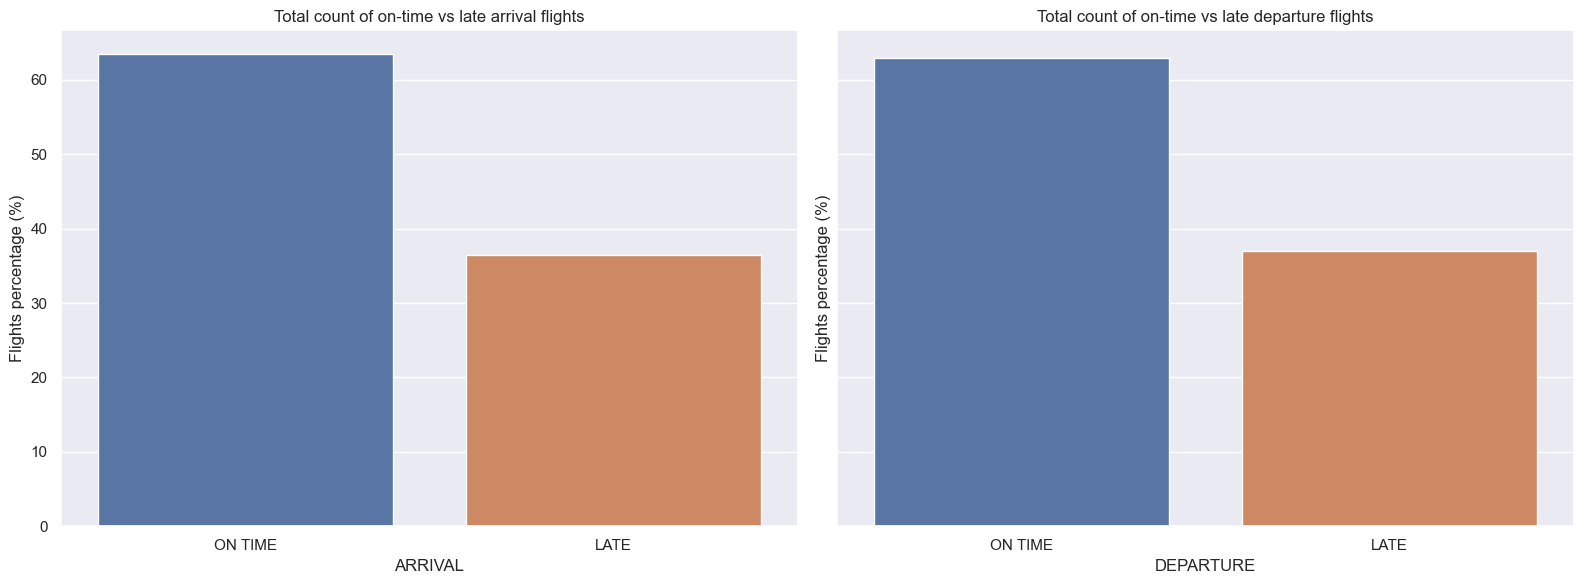

In [25]:
# How many flights are on time vs how many flights are late
print('Total number of flights: ', len(flights_df))


flights_df['LATE_ARRIVAL'] = flights_df['ARRIVAL_DELAY'] > 0
arrival_count = flights_df.groupby('LATE_ARRIVAL')['ARRIVAL_DELAY'].count()/len(flights_df)*100
arrival_count.index = ['ON TIME', 'LATE']

flights_df['LATE_DEPARTURE'] = flights_df['DEPARTURE_DELAY'] > 0
departure_count = flights_df.groupby('LATE_DEPARTURE')['DEPARTURE_DELAY'].count()/len(flights_df)*100
departure_count.index = ['ON TIME', 'LATE']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True, sharex=True)
sns.barplot(x=arrival_count.index, y=arrival_count.values, ax=ax1)
ax1.set(xlabel='ARRIVAL', ylabel='Flights percentage (%)', title='Total count of on-time vs late arrival flights')

sns.barplot(x=departure_count.index, y=departure_count.values, ax=ax2)
ax2.set(xlabel='DEPARTURE', ylabel='Flights percentage (%)', title='Total count of on-time vs late departure flights')

fig.tight_layout()
fig.show()

It seems as the percentage of on-time and late flights are the same for both departure and arrivals. This could be explained by the strong correlation between departure and arrival dealys. We could suspect that most of the time, a deperture delays impacts directly the landing delay at the destination airport. Lets check that.

Correlation matrix:
                 DEPARTURE_DELAY  ARRIVAL_DELAY
DEPARTURE_DELAY         1.000000       0.944672
ARRIVAL_DELAY           0.944672       1.000000


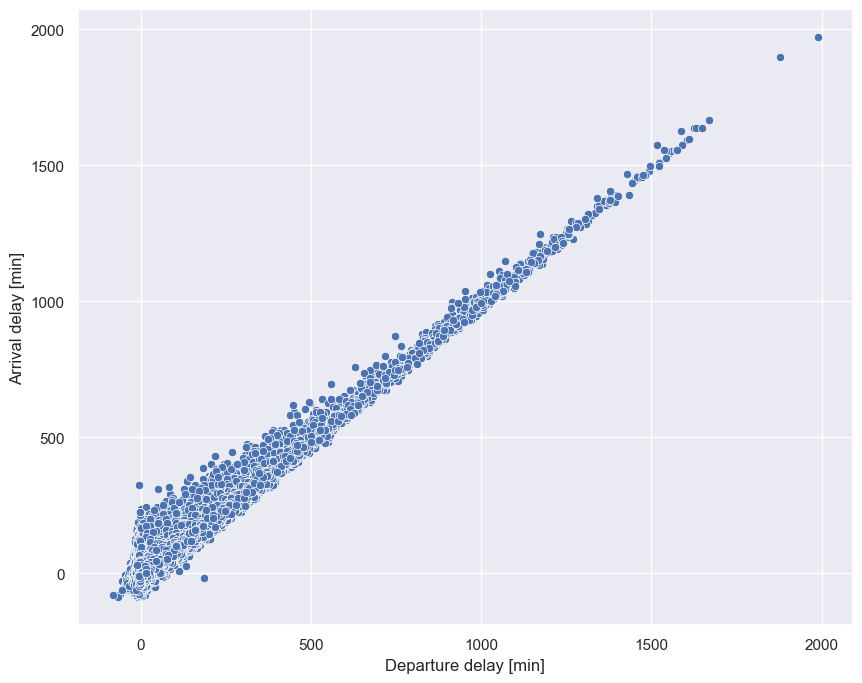

In [26]:
# check correlation between departure and arrival delays - the correlation is almost perfectly linear
print('Correlation matrix:')
print(flights_df[['DEPARTURE_DELAY', 'ARRIVAL_DELAY']].corr())

sns.scatterplot(x=flights_df['DEPARTURE_DELAY'], y=flights_df['ARRIVAL_DELAY'])
plt.xlabel('Departure delay [min]')
plt.ylabel('Arrival delay [min]')
plt.show()

We see that the two types of delays are almost perfectly correlated. We can also notice that there are quite a few flights that despite having a low departure delay have then a higher arrival delay. This can be influenced by the delays that happend between the time plane pushes out from the gate (scheduled departure time) and when it pulls into the gate at its destination airport (scheduled arrival time). These delays can be influenced, by weather, operational delays on ground (taxi time, queue time for take-off or landing, etc.).

### Airlines

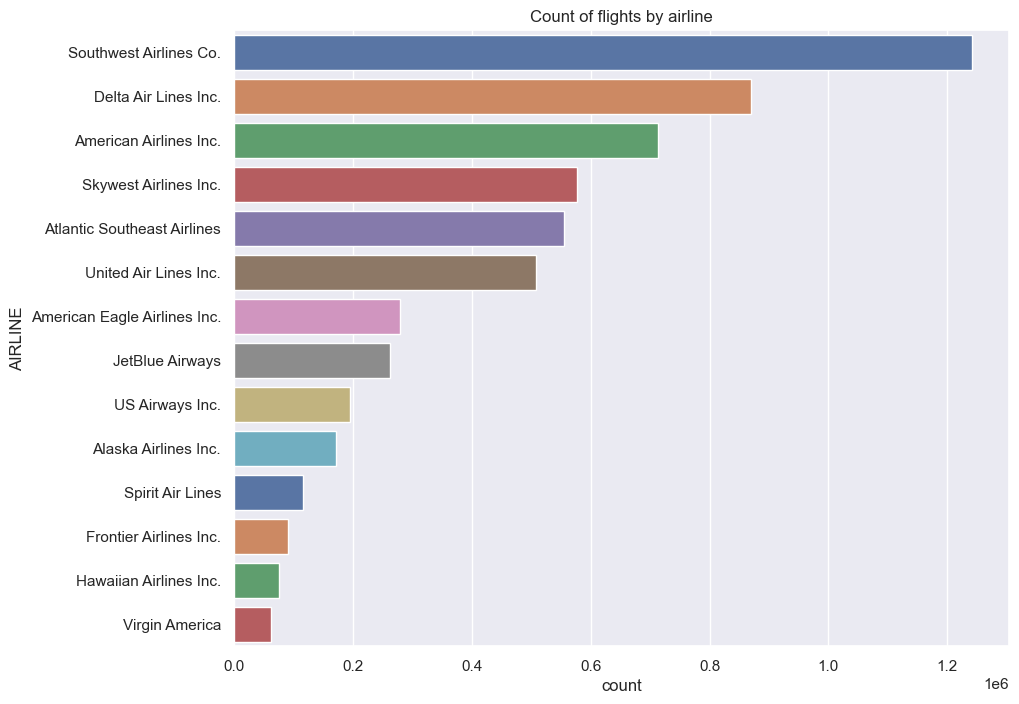

In [27]:
# Plot the number of flights per airline
flights_count = flights_df.groupby('AIRLINE')['SCHEDULED_DEPARTURE'].count().sort_values(ascending=False)

sns.countplot(flights_df, y='AIRLINE', order=flights_count.index, palette=sns.color_palette())
plt.title('Count of flights by airline')
plt.show()

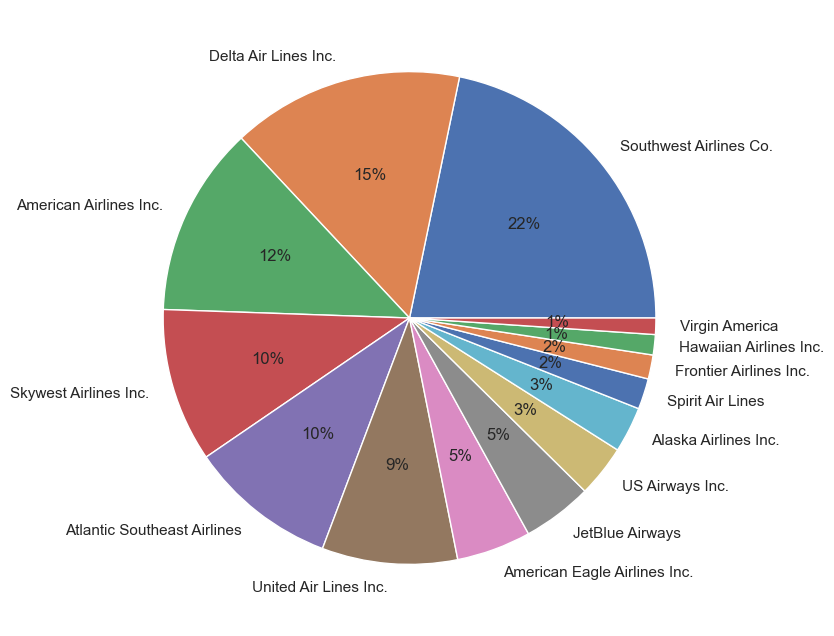

In [28]:
# pie chart for percentage distribution of number of flights
plt.pie(flights_count, labels=flights_count.index, autopct='%.0f%%')
plt.show()

The top 5 airlines with the most of flights are:
1. Southwest Airlines
2. Delta Airlines
3. American Airlines
4. Skywest Airlines
5. Atlantic Southeast Airlines

The first airline Southwest effectuates alone as many flights as the 8 bottom airlines. 

The question now is if these top airlines have also much more delays in percentage of total delays and how do their mean compare to those of smaller airlines ?

Text(0.5, 0, 'Delays percentage %')

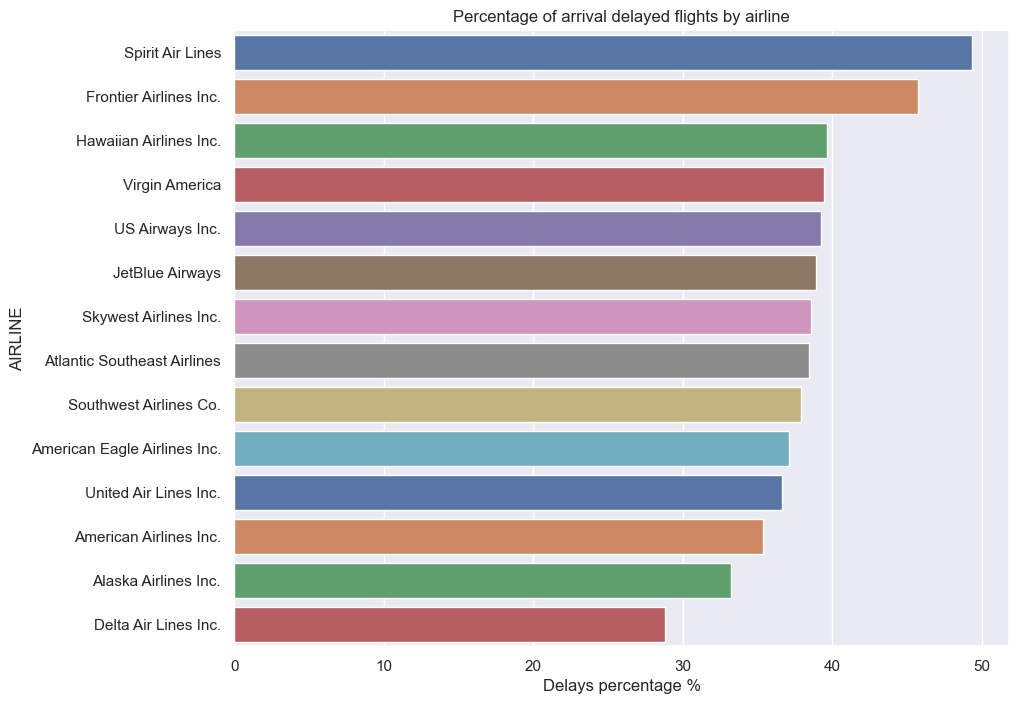

In [29]:
# Plot the percentage of delayed flights at arrival
delays_count = flights_df[flights_df['ARRIVAL_DELAY'] > 0].groupby('AIRLINE')['SCHEDULED_DEPARTURE'].count().sort_values(ascending=False)
count_df = pd.DataFrame(flights_count).join(delays_count, how='inner', lsuffix='_f')
count_df.columns = ['Flights_count', 'Delays_count']
count_df['Delays_percent'] = count_df['Delays_count']/count_df['Flights_count']*100
count_df = count_df.sort_values('Delays_percent', ascending=False)

sns.barplot(x=count_df['Delays_percent'], y=count_df.index, palette=sns.color_palette())
plt.title('Percentage of arrival delayed flights by airline')
plt.xlabel('Delays percentage %')


Now, we actually see that ou top biggest airlines are in the bottom half regarding the percentage of delayed flights. On the other end, Spirit and Frontier Airlines have almost half of their flights delayed, while being also one of the smallest airlines !

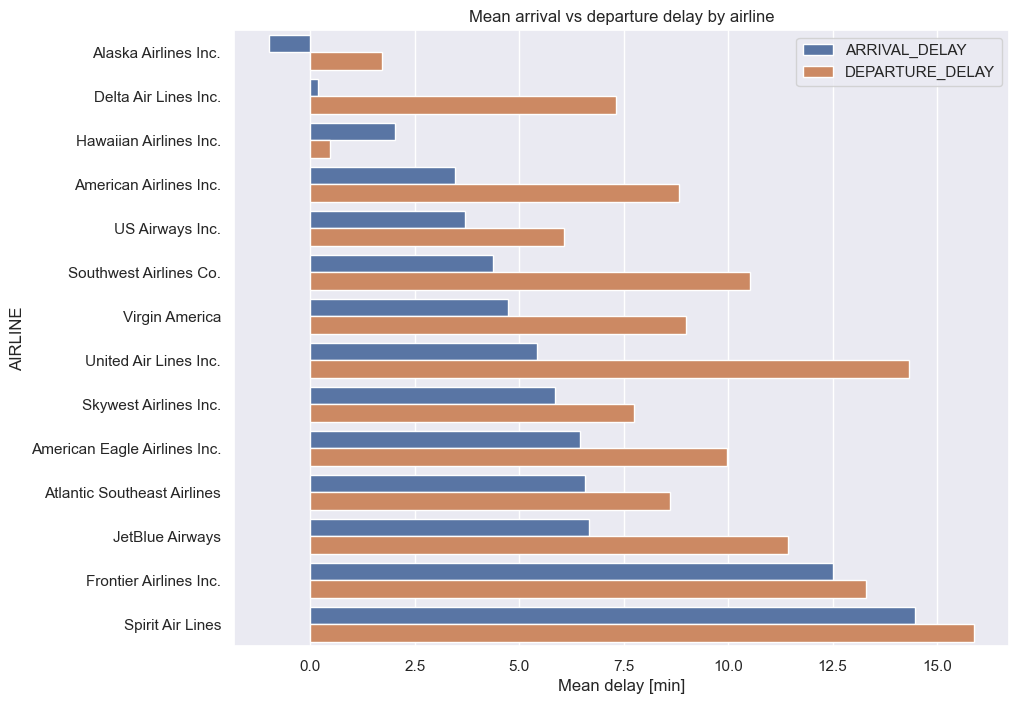

In [30]:
# Create df with mean departure and arrival delay
airline_mean_arrival_delay = flights_df.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values()
airline_mean_departure_delay = flights_df.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().sort_values()
airline_mean_delay = pd.DataFrame(airline_mean_arrival_delay).join(airline_mean_departure_delay, how='inner')
airline_mean_delay = airline_mean_delay.stack().reset_index(level=1)
airline_mean_delay.columns = ['TYPE_DELAY', 'Value']

# Plot mean departure vs arrival delay by airline
sns.barplot(airline_mean_delay, x='Value', y=airline_mean_delay.index, hue='TYPE_DELAY')

plt.xlabel('Mean delay [min]')
plt.title('Mean arrival vs departure delay by airline')
plt.legend()

We see on the barplot above that both departure and arrival delays are on average quite low, by not exceeding in general 15min ! Thus, the airlines try in general to stick to the schedule and minimize as much the delays, as possible. At the same time, average departure delays are in general larger  than arrival delays

,count,mean,std,min,25%,50%,75%,max
AIRLINE,,,,,,,,
Alaska Airlines Inc.,171439.0,-0.976563,28.678804,-82.0,-14.0,-5.0,4.0,950.0
American Airlines Inc.,712935.0,3.451372,44.266750,-87.0,-15.0,-6.0,7.0,1971.0
American Eagle Airlines Inc.,278791.0,6.457873,44.458112,-63.0,-15.0,-6.0,10.0,1528.0
Atlantic Southeast Airlines,554752.0,6.585379,40.682366,-64.0,-12.0,-4.0,9.0,1223.0
Delta Air Lines Inc.,870275.0,0.186754,38.439225,-79.0,-15.0,-8.0,3.0,1274.0
Frontier Airlines Inc.,90090.0,12.504706,51.561753,-73.0,-11.0,-1.0,16.0,1101.0
Hawaiian Airlines Inc.,76041.0,2.023093,25.714939,-67.0,-6.0,-2.0,5.0,1467.0
JetBlue Airways,262042.0,6.677861,41.400552,-76.0,-14.0,-5.0,12.0,1002.0
Skywest Airlines Inc.,576814.0,5.845652,39.257694,-69.0,-12.0,-4.0,8.0,1372.0


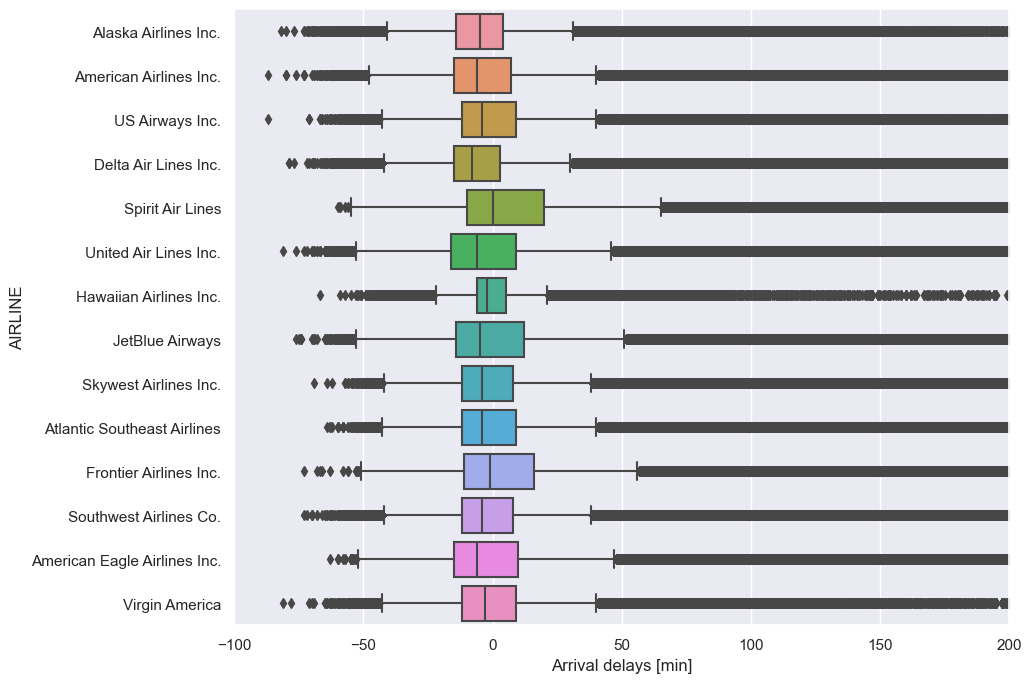

In [31]:
# boxplot to have an idea of the distribution of arrival delays per airline
sns.boxplot(flights_df, x='ARRIVAL_DELAY', y='AIRLINE')
plt.xlim((-100, 200))
plt.xlabel('Arrival delays [min]')
# numerical statistics about arrival delays
flights_df.groupby('AIRLINE')['ARRIVAL_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
AIRLINE,,,,,,,,
Alaska Airlines Inc.,171439.0,1.718926,26.139224,-82.0,-8.0,-4.0,1.0,963.0
American Airlines Inc.,712935.0,8.826106,41.712106,-68.0,-5.0,-2.0,5.0,1988.0
American Eagle Airlines Inc.,278791.0,9.967187,40.299088,-36.0,-6.0,-2.0,8.0,1544.0
Atlantic Southeast Airlines,554752.0,8.615598,38.467362,-55.0,-6.0,-3.0,4.0,1236.0
Delta Air Lines Inc.,870275.0,7.313300,36.078641,-61.0,-4.0,-1.0,4.0,1289.0
Frontier Airlines Inc.,90090.0,13.303352,49.440177,-46.0,-7.0,-2.0,12.0,1112.0
Hawaiian Airlines Inc.,76041.0,0.469918,24.412891,-27.0,-7.0,-4.0,1.0,1433.0
JetBlue Airways,262042.0,11.442467,38.360688,-31.0,-5.0,-2.0,11.0,1006.0
Skywest Airlines Inc.,576814.0,7.736083,37.660917,-56.0,-6.0,-3.0,4.0,1378.0


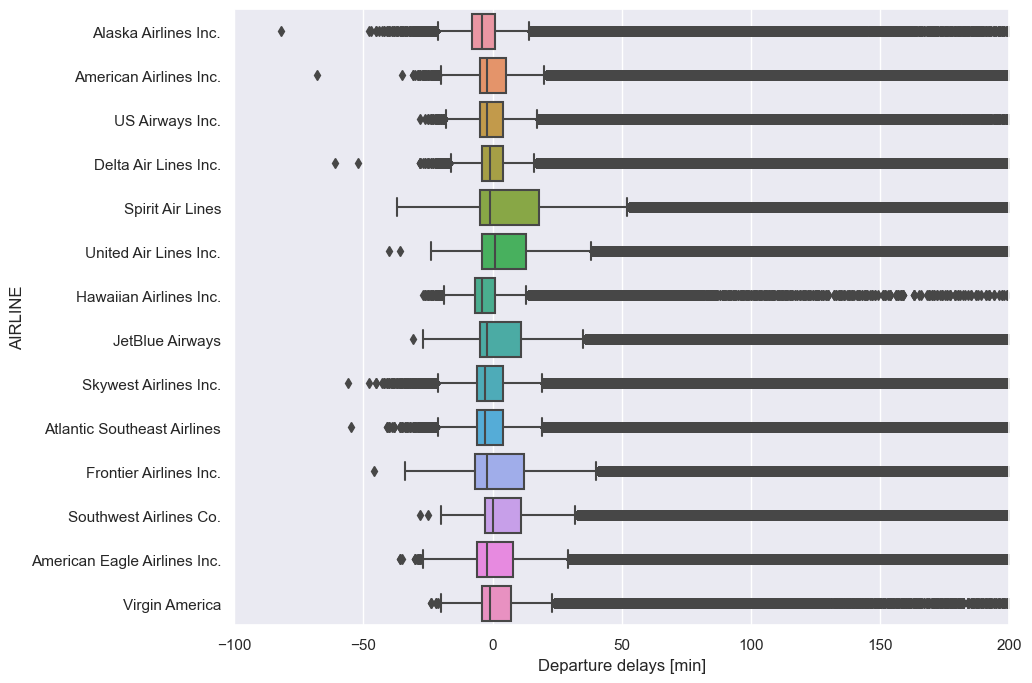

In [32]:
# same for departure delays
sns.boxplot(flights_df, x='DEPARTURE_DELAY', y='AIRLINE')
plt.xlim((-100, 200))
plt.xlabel('Departure delays [min]')

flights_df.groupby('AIRLINE')['DEPARTURE_DELAY'].describe()

From the above boxplots, we notice that the departures delays distribution for each airline are more right-skewed than the arrival delays distributions. Moreover, all airlines tend to have more early arrivals than early departures. 

Looking at the arrival delays boxplots, we notice that even if most mean delays are positive, the median value for most of the airlines is actually negative. This difference between mean and median delays is influenced by some very large delays experienced by all airlines that are marked as outliers on our boxplots.

When inspecting the delays statistics dataframes, we see that some delays can even exceed 15 hours !

In general, passengers can expect compensations from the airline if their flight is delayed more then 3 hours, thus we could define all delays larger than that as outliers and get rid of them for our prediction model. This aligns with what can be observed on our boxplots, where actually for all airlines values larger than 60 minutes are considered outliers, as they occur very rarely compared to usual delays value. Nevertheless, for now we keep all data for the rest of EDA and we will proceed with a second step of data cleaning before building our prediction models.

#### Airline arrival delays time-series

In [33]:
# we want to plot the time series of arrival delays for all airlines by first highlighting Delta Air Lines vs Spirit Air Lines
fig = px.line(flights_df.groupby(['AIRLINE', 'DATE'])['ARRIVAL_DELAY'].mean().unstack(level=0), labels={'value': 'Mean arrival delay [min]'})
fig.update_traces(visible="legendonly", selector=lambda x: not x.name in ['Delta Air Lines Inc.', 'Spirit Air Lines'])
fig.show()

### Airports

In [34]:
# First we add origin/destination city and state column for each flight
flights_df['ORIGIN_CITY'] = flights_df['ORIGIN_AIRPORT'].map(airports_df['CITY'].to_dict())
flights_df['DESTINATION_CITY'] = flights_df['DESTINATION_AIRPORT'].map(airports_df['CITY'].to_dict())
flights_df['ORIGIN_STATE'] = flights_df['ORIGIN_AIRPORT'].map(airports_df['STATE'].to_dict())
flights_df['DESTINATION_STATE'] = flights_df['DESTINATION_AIRPORT'].map(airports_df['STATE'].to_dict())
# then we map airports IATA codes to airport names and 
flights_df['ORIGIN_AIRPORT'] = flights_df['ORIGIN_AIRPORT'].map(airports_df['AIRPORT'].to_dict())
flights_df['DESTINATION_AIRPORT'] = flights_df['DESTINATION_AIRPORT'].map(airports_df['AIRPORT'].to_dict())
flights_df['CITY_CONNECTION'] = flights_df['ORIGIN_CITY'] + ' - ' + flights_df['DESTINATION_CITY']

Text(0.5, 1.0, 'Top 20 destination airports vs mean delay')

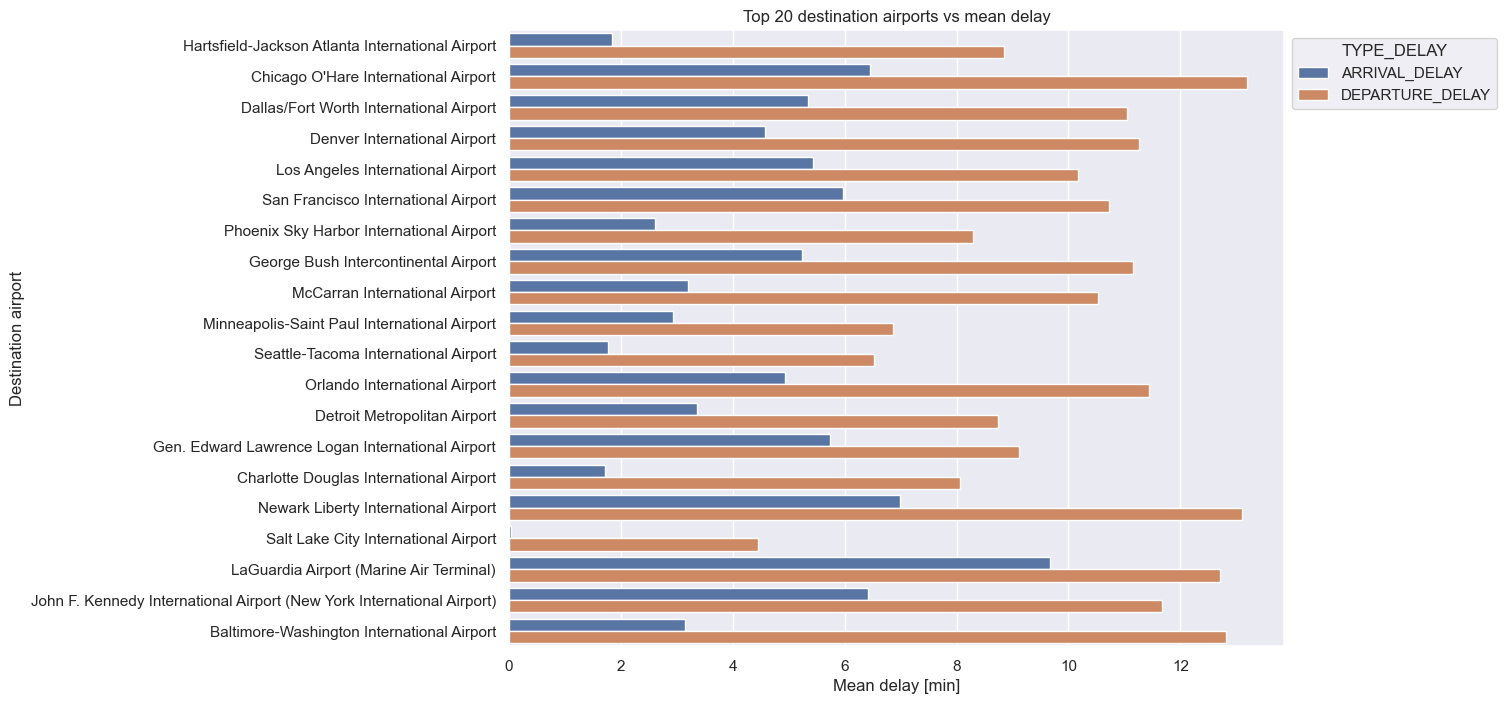

In [57]:
# Plot the mean arrival vs departure delay time for the top 20 destinations airports
# actually the top 20 airports is the same for both departures and destinations as only San Fransisco and Phoenix Sky HArbor change places in both rankings

# Mean arrival delay of the top 20 arrival airports
flight_airport_count = flights_df.groupby('DESTINATION_AIRPORT')['SCHEDULED_DEPARTURE'].count().sort_values(ascending=False).head(20)
airport_mean_arrival_delay = flights_df.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean()
airport_mean_arrival_delay = airport_mean_arrival_delay.loc[flight_airport_count.index]

# Mean departure delay of the top 20 arrival airports 
airport_mean_departure_delay = flights_df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean()
airport_mean_departure_delay = airport_mean_departure_delay.loc[flight_airport_count.index]

airport_mean_delay = pd.DataFrame(airport_mean_arrival_delay).join(airport_mean_departure_delay, how='inner')
airport_mean_delay = airport_mean_delay.stack().reset_index(level=1)
airport_mean_delay.columns = ['TYPE_DELAY', 'Value']

# Plot mean departure vs arrival delay by airports from top 20 destinations
ax = sns.barplot(airport_mean_delay, x='Value', y=airport_mean_delay.index, hue='TYPE_DELAY')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.xlabel('Mean delay [min]')
plt.ylabel('Destination airport')
plt.title('Top 20 destination airports vs mean delay')

In [56]:
flights_df

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,...,LATE_ARRIVAL,LATE_DEPARTURE,ORIGIN_CITY,DESTINATION_CITY,ORIGIN_STATE,DESTINATION_STATE,CITY_CONNECTION,HOUR,DAY,MONTH
0,4,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,00:05:00,23:54:00,-11.0,21.0,205.0,1448,...,False,False,Anchorage,Seattle,AK,WA,Anchorage - Seattle,0,1,1
1,4,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport,00:10:00,00:02:00,-8.0,12.0,280.0,2330,...,False,False,Los Angeles,West Palm Beach,CA,FL,Los Angeles - West Palm Beach,0,1,1
2,4,US Airways Inc.,San Francisco International Airport,Charlotte Douglas International Airport,00:20:00,00:18:00,-2.0,16.0,286.0,2296,...,True,False,San Francisco,Charlotte,CA,NC,San Francisco - Charlotte,0,1,1
3,4,American Airlines Inc.,Los Angeles International Airport,Miami International Airport,00:20:00,00:15:00,-5.0,15.0,285.0,2342,...,False,False,Los Angeles,Miami,CA,FL,Los Angeles - Miami,0,1,1
4,4,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport,00:25:00,00:24:00,-1.0,11.0,235.0,1448,...,False,False,Seattle,Anchorage,WA,AK,Seattle - Anchorage,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5714003,4,JetBlue Airways,Los Angeles International Airport,Gen. Edward Lawrence Logan International Airport,23:59:00,23:55:00,-4.0,22.0,320.0,2611,...,False,False,Los Angeles,Boston,CA,MA,Los Angeles - Boston,23,31,12
5714004,4,JetBlue Airways,John F. Kennedy International Airport (New Yor...,Mercedita Airport,23:59:00,23:55:00,-4.0,17.0,227.0,1617,...,False,False,New York,Ponce,NY,PR,New York - Ponce,23,31,12
5714005,4,JetBlue Airways,John F. Kennedy International Airport (New Yor...,Luis Muñoz Marín International Airport,23:59:00,23:50:00,-9.0,17.0,221.0,1598,...,False,False,New York,San Juan,NY,PR,New York - San Juan,23,31,12
5714006,4,JetBlue Airways,Orlando International Airport,Luis Muñoz Marín International Airport,23:59:00,23:53:00,-6.0,10.0,161.0,1189,...,False,False,Orlando,San Juan,FL,PR,Orlando - San Juan,23,31,12


In [55]:
flights_df.groupby('DESTINATION_AIRPORT')['SCHEDULED_DEPARTURE'].count().sort_values(ascending=False).head(20)

DESTINATION_AIRPORT
Hartsfield-Jackson Atlanta International Airport                          375622
Chicago O'Hare International Airport                                      303370
Dallas/Fort Worth International Airport                                   252225
Denver International Airport                                              211098
Los Angeles International Airport                                         209783
San Francisco International Airport                                       159492
Phoenix Sky Harbor International Airport                                  158262
George Bush Intercontinental Airport                                      156659
McCarran International Airport                                            144788
Minneapolis-Saint Paul International Airport                              121746
Seattle-Tacoma International Airport                                      120542
Orlando International Airport                                             118568
Detroit 

Text(0.5, 1.0, 'Top 20 city connection flights with lowest mean arrival delay')

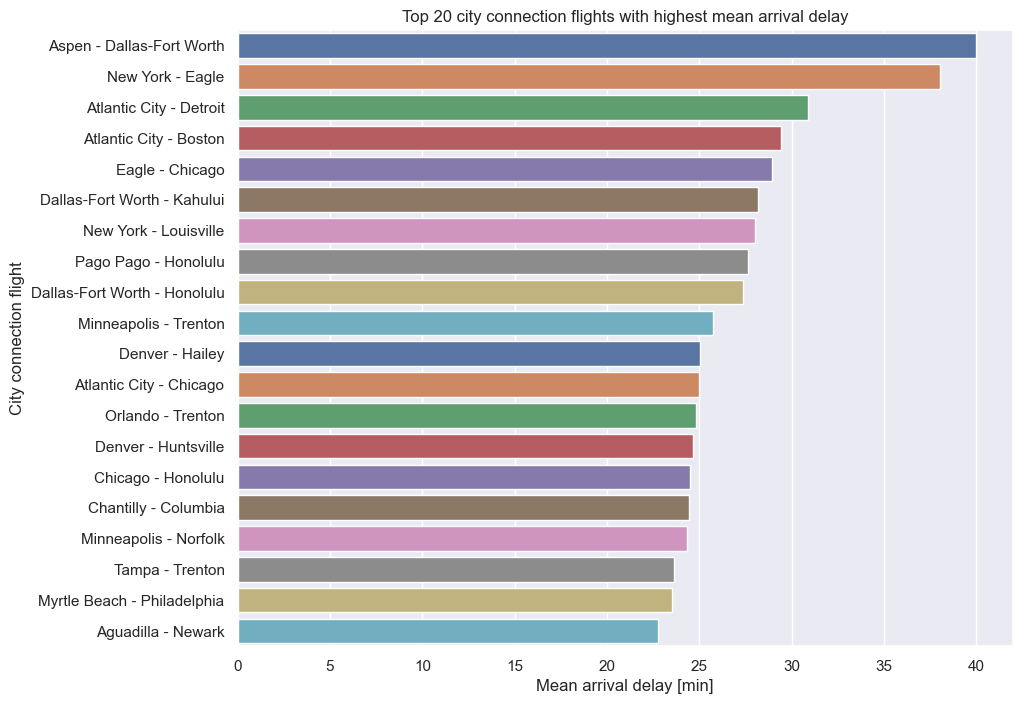

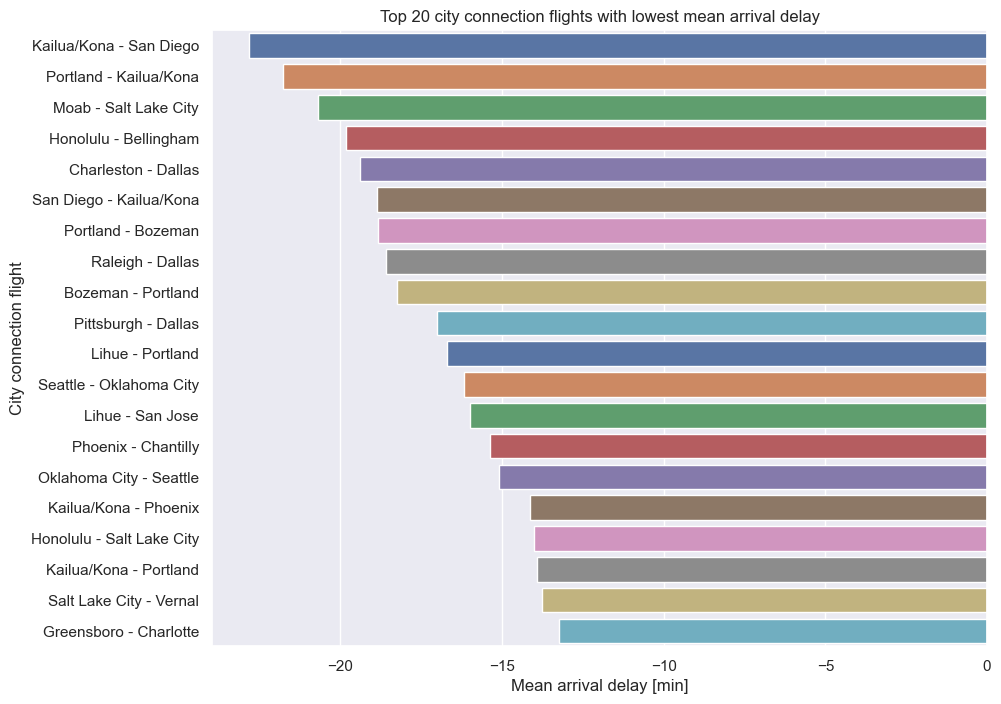

In [36]:
# Let also see the top 20 city connections with the highest mean arrival delays
# However we have to keep in mind that some flights can be very rare but have large delays - that will automatically make them appear in the top 20
# therefore we only take city-connection flights that occured more than 100 times and then evaluate their mean arrival delay
city_connections_count = flights_df.groupby('CITY_CONNECTION')['ARRIVAL_DELAY'].count()
not_rare_flights = city_connections_count[city_connections_count > 100].index

high_delay_connections = flights_df.groupby('CITY_CONNECTION')['ARRIVAL_DELAY'].mean().loc[not_rare_flights].sort_values(ascending=False).head(20)
# plot
sns.barplot(x=high_delay_connections.values, y=high_delay_connections.index, palette=sns.color_palette())
plt.xlabel('Mean arrival delay [min]')
plt.ylabel('City connection flight')
plt.title('Top 20 city connection flights with highest mean arrival delay')

# what about the top city connections with lowest mean arrival delays ?
low_delay_connections = flights_df.groupby('CITY_CONNECTION')['ARRIVAL_DELAY'].mean().loc[not_rare_flights].sort_values(ascending=True).head(20)
# plot
plt.figure()
sns.barplot(x=low_delay_connections.values, y=low_delay_connections.index, palette=sns.color_palette())
plt.xlabel('Mean arrival delay [min]')
plt.ylabel('City connection flight')
plt.title('Top 20 city connection flights with lowest mean arrival delay')

Is is worth noting that surprisingly, all city connections flights within the top 20 with lowest mean arrival delays are all on average landing before the scheduled time. That could indicate that passengers could expect when taking on of these routes that their flight would arrive early. 

Text(0.5, 1.0, 'Mean arrival delay of the top 20 most frequent city-connection flights ')

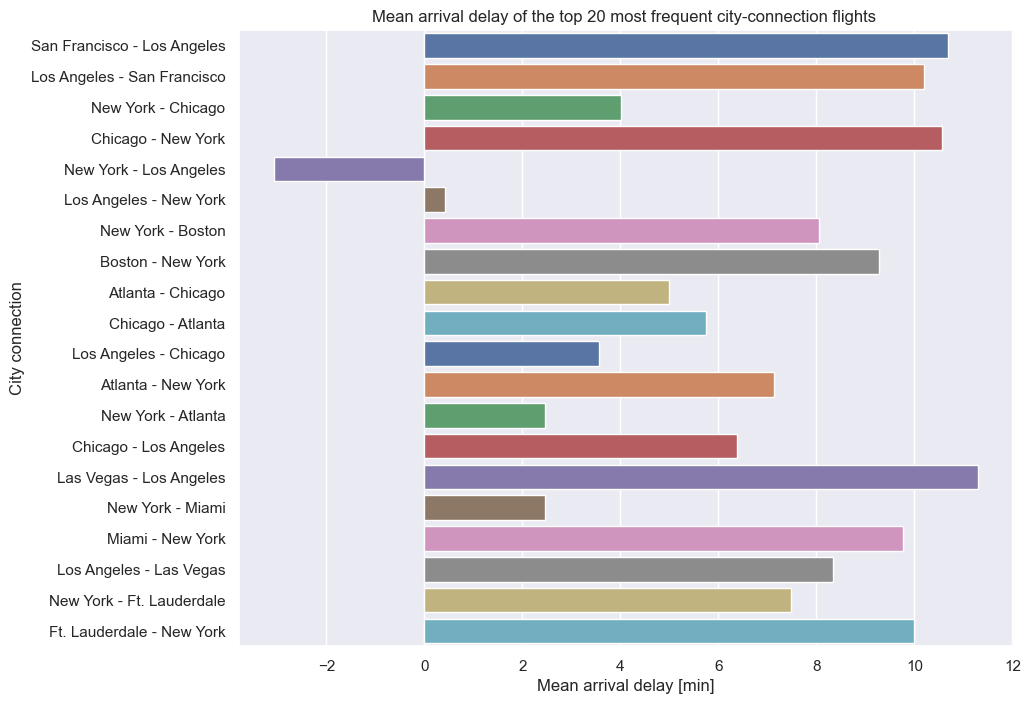

In [42]:
# how does it compare to city-connections with the most flights ?
# Mean arrival delay of the top 20 arrival airports
connection_count = flights_df.groupby('CITY_CONNECTION')['ARRIVAL_DELAY'].count().sort_values(ascending=False).head(20)
connection_mean_arrival_delay = flights_df.groupby('CITY_CONNECTION')['ARRIVAL_DELAY'].mean()
connection_mean_arrival_delay = connection_mean_arrival_delay.loc[connection_count.index]

# plot
sns.barplot(x=connection_mean_arrival_delay.values, y=connection_mean_arrival_delay.index, palette=sns.color_palette())
plt.xlabel('Mean arrival delay [min]')
plt.ylabel('City connection')
plt.title('Mean arrival delay of the top 20 most frequent city-connection flights ')

Here, the connection New York-Los Angeles stands out of the crowd, as on average these flights arrive earlier than scheduled despite the fact that it is the 5th most frequent flight connection in our dataset.

Text(0.5, 1.0, 'Top 20 destination states with highest mean arrival delays')

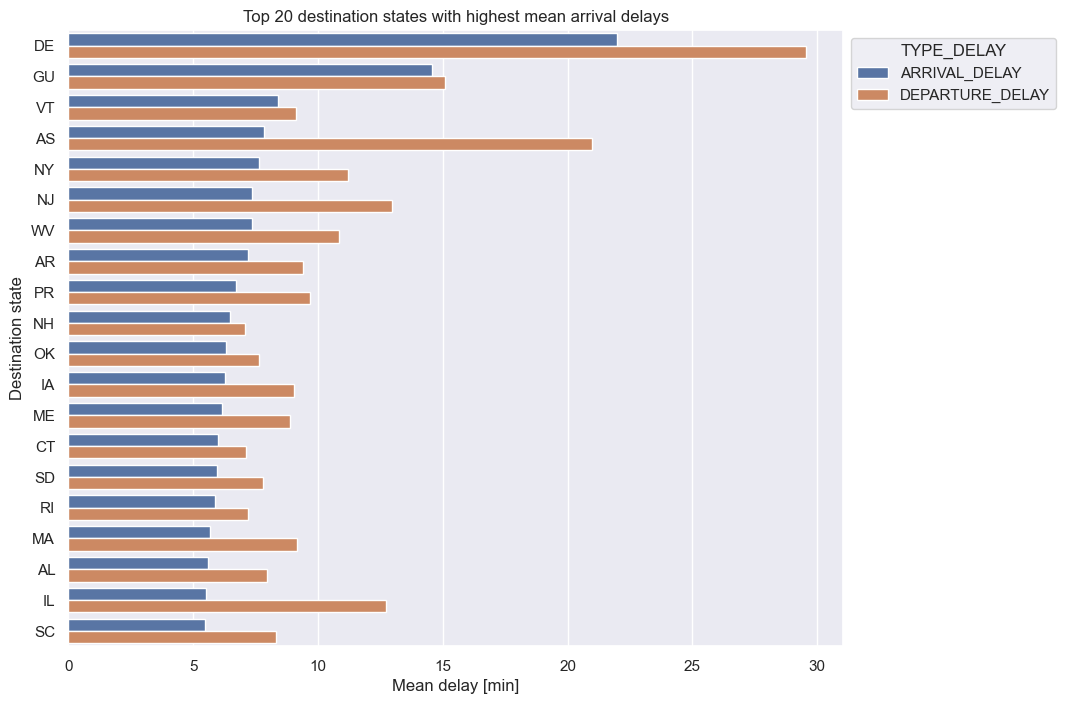

In [46]:
# Top 20 states with the highest mean arrival delay
state_mean_arrival_delay = flights_df.groupby('DESTINATION_STATE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False).head(20)

# Mean departure delay of the top 20 arrival airports 
state_mean_departure_delay = flights_df.groupby('ORIGIN_STATE')['DEPARTURE_DELAY'].mean()

state_mean_delay = pd.DataFrame(state_mean_arrival_delay).join(state_mean_departure_delay, how='inner')
state_mean_delay = state_mean_delay.stack().reset_index(level=1)
state_mean_delay.columns = ['TYPE_DELAY', 'Value']

# Plot mean departure vs arrival delay by airports from top 20 destinations
ax = sns.barplot(state_mean_delay, x='Value', y=state_mean_delay.index, hue='TYPE_DELAY')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.xlabel('Mean delay [min]')
plt.ylabel('Destination state')
plt.title('Top 20 destination states with highest mean arrival delays')

### Time of the day, day of week and month vs delays

In [39]:
# extract hour, day and month from scheduled departure datetime
flights_df['HOUR'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour)
flights_df['DAY'] = flights_df['DATE'].apply(lambda x: x.day)
flights_df['MONTH'] = flights_df['DATE'].apply(lambda x: x.month)

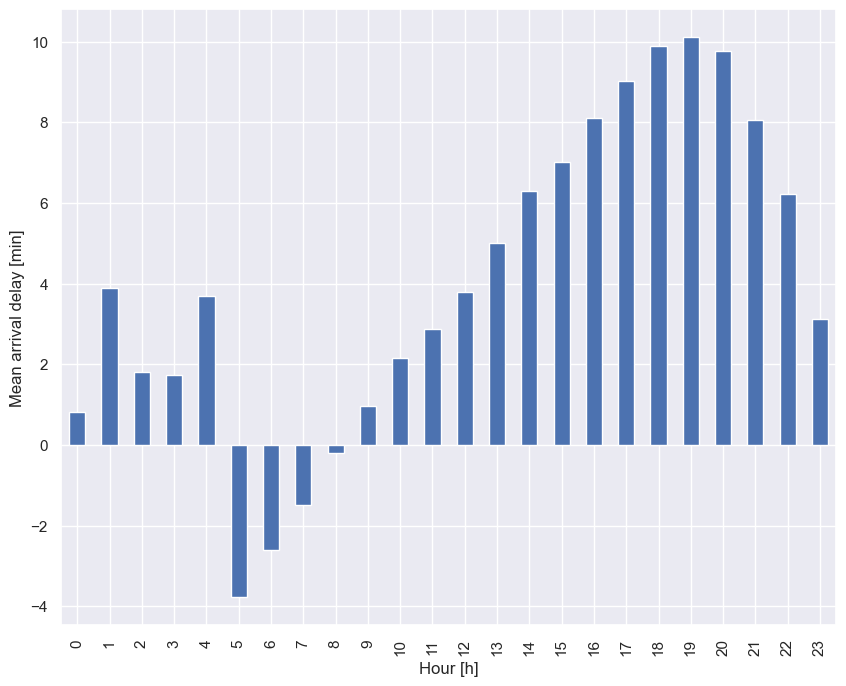

In [40]:
# aggregate arrival delays by hour, day, day of week and month to see if there are any conclusion to take from that
hour_delays = flights_df.groupby('HOUR')['ARRIVAL_DELAY'].mean()
day_delays = flights_df.groupby('DAY')['ARRIVAL_DELAY'].mean()
day_of_week_delays = flights_df.groupby('DAY_OF_WEEK')['ARRIVAL_DELAY'].mean()
month_delays = flights_df.groupby('MONTH')['ARRIVAL_DELAY'].mean()

# plots
plt.figure()
hour_delays.plot.bar()
plt.xlabel('Hour [h]')
plt.ylabel('Mean arrival delay [min]')

# it is worth noting that most airlines seem to not operate between 2am and 5am as can be seen on the plot below
hour_airline_delays = flights_df.groupby(['AIRLINE', 'HOUR'])['ARRIVAL_DELAY'].mean().unstack(level=0)
px.line(hour_airline_delays, labels={'value': 'mean arrival delay'})

Text(0, 0.5, 'Mean arrival delay [min]')

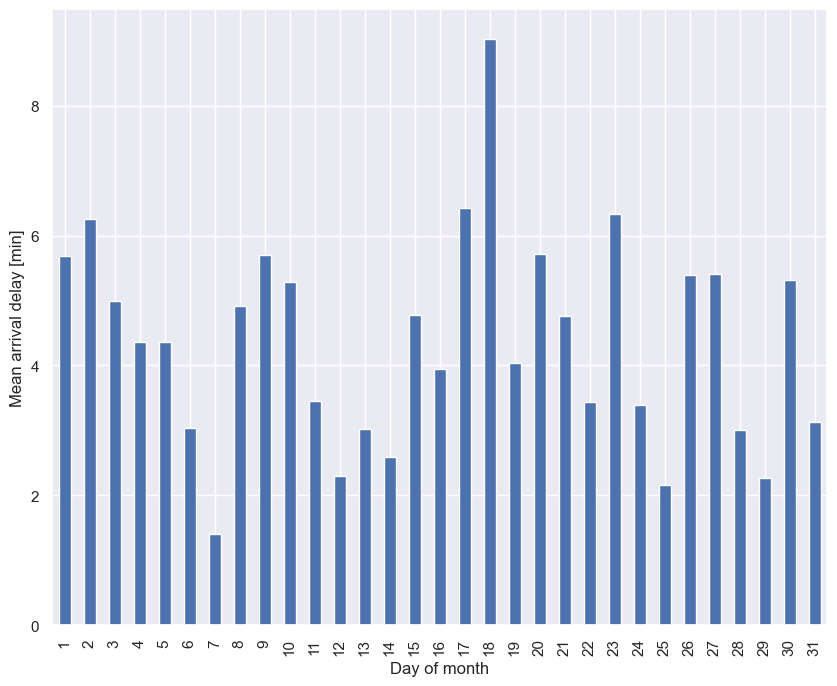

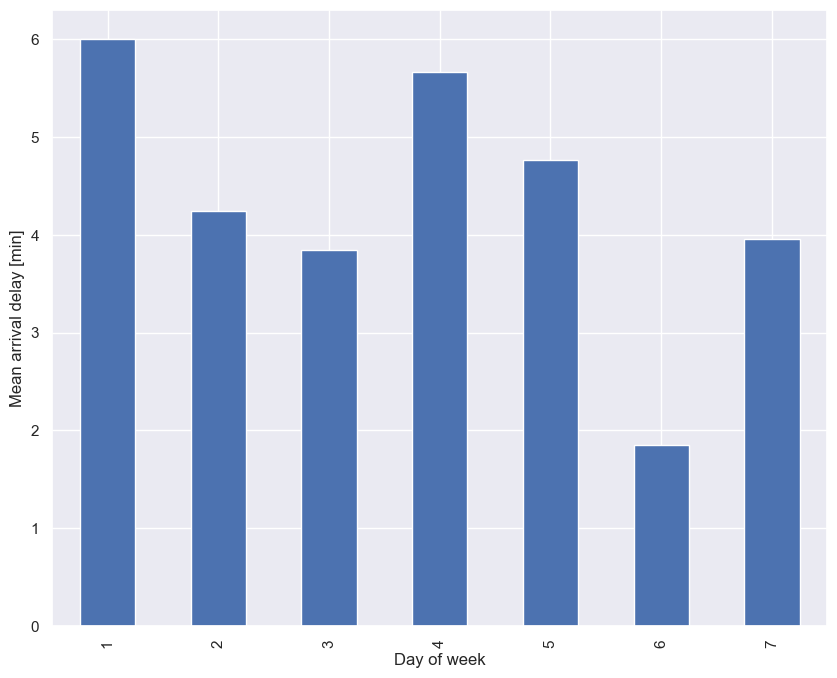

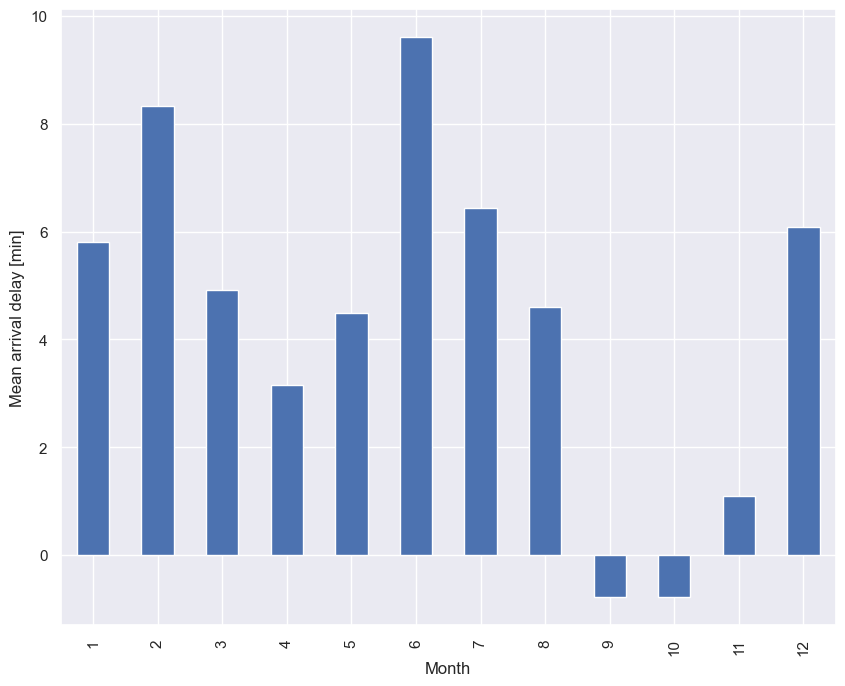

In [41]:
# plot for day of month, day of week and month 
plt.figure()
day_delays.plot.bar()
plt.xlabel('Day of month')
plt.ylabel('Mean arrival delay [min]')

plt.figure()
day_of_week_delays.plot.bar()
plt.xlabel('Day of week')
plt.ylabel('Mean arrival delay [min]')

plt.figure()
month_delays.plot.bar()
plt.xlabel('Month')
plt.ylabel('Mean arrival delay [min]')

From the above graphs, we can make several observations:
- on average the smallest delays occur between 5am and 8am (the flights even tend to arrive early at these hours) and the delay then increase more towards the day until they peak in the evening hours; this is totally logical as delays from the early hours of the day tend to provoke later delays by creating a domino effect
- average delays are more or less stable during the different days of the month - no clear insights 
- the smallest mean delay occur on Saturday flights
- the smallest delays tend to be during the months of October and November, while the largest are during the months of holidays (summer, Christmas and winter holidays in February) 